**NeuroNet: Deep Learning for Brain MRI Tumor Classification**

I have designed the NeuroNet model to classify brain tumors from MRI scans utilizing the VGG19 model pre-trained on the ImageNet dataset. The VGG19 model is a robust deep learning model, which has a top-5 test accuracy exceeding 90% on ImageNet's cross validation set. I have trained and fine-tuned my model on a comprehensive dataset of over 5700 MRI scans derived from figshare, SARTAJ, and Br35H. I have also used Keras Fine Tuner, adjustments to VGG19 layers, and Dense and Dropout layers to optimize my model's performance. As a result, my model was able to **achieve an accuracy of 97.7% on the test set**, which is unseen data.

First, let's declare the imports for this project. Scikit learn was used for metrics and shuffling training data. TensorFlow Keras API was used to build the model and load the pretrained VGG19 model for transfer learning. Keras Tuner class was used for hyperparamter optimization. Albumentations library was used for image augmentation. I also used OpenCV was used to read and resize the images. 

In [ ]:
!pip install keras-tuner

In [ ]:
import numpy as np 
import pandas as pd

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.callbacks import EarlyStopping
import albumentations as A

import matplotlib.pyplot as plt

import cv2
import os

Next, we define a function to load all of the training and cross validation images. I have chosen an image size of 128x128. The images will be saved as 3D NumPy arrays and the target/output labels are arrays with 4 possible classes.

In [2]:
def load_images_and_labels(categories):
    img_size = 128 #each image will be 128 x 128
    data = [] #array to store images
    labels = [] #array to store targets

    for category in categories:
        path = os.path.join('/kaggle/input/brain-tumor-mri-dataset/', category) 
        target_class = categories.index(category) #output target class

        for file in os.listdir(path):  
            image_path = os.path.join(path, file)
            image = cv2.imread(image_path) #read the image

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #convert to RBG format
            image = cv2.resize(image, (img_size, img_size)) #resize image
            image = np.array(image, dtype=np.float32) #convert to NumPy array
            image /= 255.0 #normalize channel values

            data.append(image)
            labels.append(target_class)

    return np.array(data), np.array(labels)

In [3]:
categories = ['Training/glioma', 'Training/meningioma', 'Training/notumor', 'Training/pituitary']
train_data, train_labels = load_images_and_labels(categories) #retrieve training data and target labels

test_categories=['Testing/glioma','Testing/meningioma','Testing/notumor','Testing/pituitary']
CV_data, CV_labels = load_images_and_labels(test_categories) #retrieve cross validation data and output labels

In [4]:
#shuffle the training data to ensure the model receives a mixture of classes for each batch (prevents fitting to order)
train_data, train_labels = shuffle(train_data, train_labels, random_state=42)

Now, let's visualize the labeled training data to understand the type of images present in each class. The plot will be created using matplotlib.


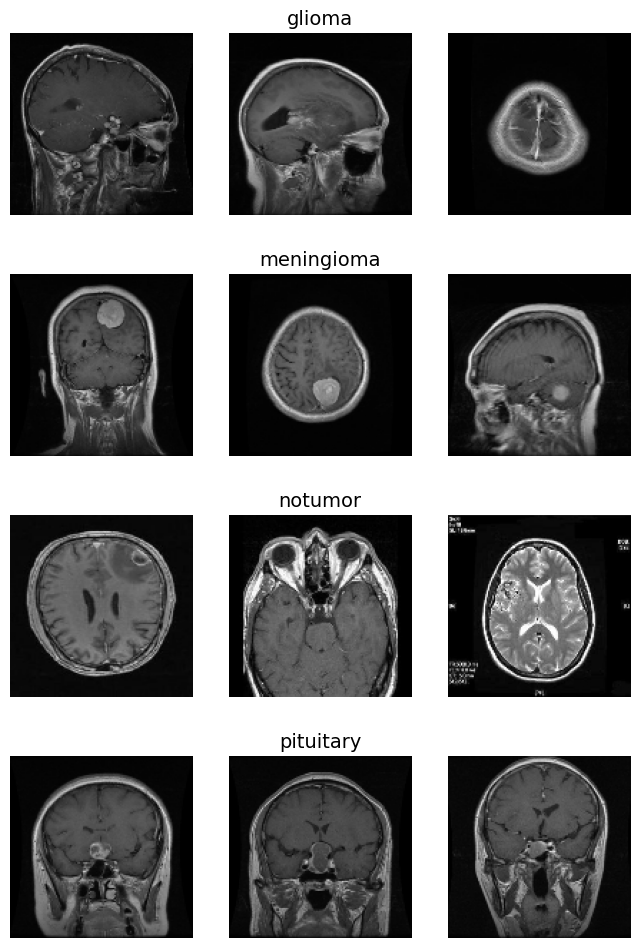

In [5]:
tumor_classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

fig, axs = plt.subplots(4, 3, figsize=(8, 12)) 

for i, class_name in enumerate(tumor_classes):
    idxs = np.where(train_labels == i)[0]

    for j in range(3): 
        random_img_idx = np.random.choice(idxs) # choose random image index for current class
        img = train_data[random_img_idx]

        axs[i, j].imshow(img) # show images using OpenCV
        axs[i, j].axis('off')
        if j == 1: # add class name for each row
            axs[i, j].set_title(class_name, fontsize=14)

plt.show()

**Image/Data Augmentation**

In order to improve the robustness of the model, I have decided to augment the images by adjusting their contrast, zooming and rotation. Only slight modifications will be made, as the dataset does not include large deviations and MRI scans are generally of high quality. I will make use of the ImageDataGenerator class from Keras to generate batches of training images, each with randomized transformations applied to them.

In [6]:
# defining augmentation pipeline
transform = A.Compose([
    A.Rotate(limit=5, p=0.1),
    A.RandomBrightnessContrast(p=0.1,contrast_limit=0.1), # random contrast adjustment
    A.RandomScale(scale_limit=0.1, p=0.1), # random zooming of image
    A.Resize(128, 128, 3)
])

augmented_images = np.array([transform(image=image)['image'] for image in train_data])

**Transfer Learning Using VGG19 Model**

Now, we will load the pretrained VGG19 model's weights for the imagenet dataset. We will remove the 3 fully connected layers at the end of the model for our brain tumor classification task (4 classes). I have made the last 3 layers of the VGG19 model trainable in order to provide flexibility for the parameters (higher level features) to adjust to brain MRI specific data.

In [7]:
pretrained_VGG = VGG19(
    include_top = False,
    weights = 'imagenet',
    input_shape = (128,128,3),
)

for layer in pretrained_VGG.layers:
    layer.trainable = False
    
pretrained_VGG.layers[-1].trainable = True
pretrained_VGG.layers[-2].trainable = True
pretrained_VGG.layers[-3].trainable = True

80134624/80134624 [==============================] - 0s 0us/step


In [8]:
pretrained_VGG.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

I have decided to use global average pooling on the output of the last convolutional block, which has dimensions of (batch_size, 4,4,512), in order to reduce dimensionality of feature space to (batch_size, 512) while also retaining spatial information. Note that the final layer has a linear activation function and when specifying the loss, I made use of from_logits = True, in order to increase computational efficiency slightly.

In [9]:
initial_model = Sequential()
initial_model.add(Input(shape=(128,128,3)))
initial_model.add(pretrained_VGG)
initial_model.add(tf.keras.layers.GlobalAveragePooling2D(data_format='channels_last'))
initial_model.add(Dense(64,activation='relu'))
initial_model.add(Dropout(0.2))
initial_model.add(Dense(4,activation='linear'))

initial_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True
),metrics=['accuracy'])

We can plot the history of the training and cross validation loss to obeserve any signs of variance and bias. We observe that the training set has slightly lower loss than the cross validation set, indicating that we can generalize a little better. Soon, I will employ hyperparameter optimization to address this point.

Epoch 1/10
179/179 [==============================] - 26s 87ms/step - loss: 0.6324 - accuracy: 0.7423 - val_loss: 0.6350 - val_accuracy: 0.7643
Epoch 2/10
179/179 [==============================] - 12s 69ms/step - loss: 0.3557 - accuracy: 0.8690 - val_loss: 0.3205 - val_accuracy: 0.8780
Epoch 3/10
179/179 [==============================] - 13s 70ms/step - loss: 0.2456 - accuracy: 0.9063 - val_loss: 0.2688 - val_accuracy: 0.8963
Epoch 4/10
179/179 [==============================] - 13s 70ms/step - loss: 0.2089 - accuracy: 0.9216 - val_loss: 0.2697 - val_accuracy: 0.9039
Epoch 5/10
179/179 [==============================] - 13s 71ms/step - loss: 0.1795 - accuracy: 0.9336 - val_loss: 0.1893 - val_accuracy: 0.9260
Epoch 6/10
179/179 [==============================] - 13s 72ms/step - loss: 0.1682 - accuracy: 0.9340 - val_loss: 0.1952 - val_accuracy: 0.9184
Epoch 7/10
179/179 [==============================] - 13s 74ms/step - loss: 0.1290 - accuracy: 0.9515 - val_loss: 0.2168 - val_accuracy:

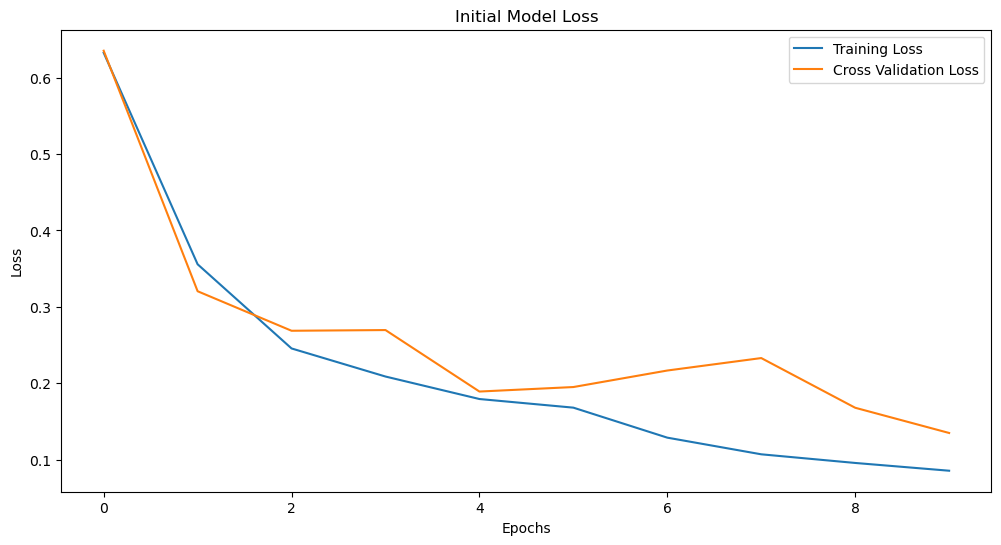

In [10]:
history = initial_model.fit(augmented_images, train_labels, epochs = 10, batch_size = 32, validation_data = (CV_data, CV_labels))

# Plot the training and validation loss
plt.figure(figsize=(12, 6))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Cross Validation Loss')

plt.title('Initial Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [11]:
predictions = initial_model.predict(CV_data)
predictions = np.argmax(predictions,axis=1)
accuracy = accuracy_score(y_true = CV_labels, y_pred = predictions)
print(accuracy)

41/41 [==============================] - 2s 51ms/step
0.9519450800915332


**We have already achieved a 95.2% accuracy on the cross validation set in identifying the 4 classes, but this can be further improved.**

Now, I will employ a called hyperparameter optimization through the KerasTuner framework. We create the seach base within the build_model function defined below. I have decided to optimize on learning rate, dropout rate and number of units in the fully connected layer at the end of the network. It is important to note that we will be optimizing the search for hyperparameters on the cross validation set, so we are required to create a test set and report the accuracy of the test set as the overall accuracy of NeuroNet.

In [12]:
from sklearn.model_selection import train_test_split
X_CV, X_test, y_CV, y_test = train_test_split(CV_data, CV_labels, test_size = 1/2, random_state = 42)

In [13]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(128,128,3)))
    model.add(pretrained_VGG)
    model.add(tf.keras.layers.GlobalAveragePooling2D(data_format='channels_last'))
    model.add(Dense(units=hp.Int('dense_unit', min_value=64, max_value=256, step=64), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.3, step=0.1)))
    model.add(Dense(4, activation='linear'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    return model

In [17]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    project_name='tumor_classification')

In [ ]:
tuner.search(augmented_images, 
             train_labels, 
             epochs=20, 
             validation_data=(X_CV, y_CV))

Trial 20 Complete [00h 01m 21s]
val_accuracy: 0.9526717662811279

Best val_accuracy So Far: 0.972540020942688
Total elapsed time: 00h 23m 11s
INFO:tensorflow:Oracle triggered exit

We will also implement early stopping so that the model does not need to be unecessaruly trained if performance on the cross validation set is no longer increasing. 

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

#early stopping criteria: model trains until the validation_loss stops increasing after 3 epochs. Note that I have sent restore_best_weights to True so even if the model starts overfitting, the best model will be chosen
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#build model using the best hyperparameters found by Keras tuner
best_hyperparameters = tuner.get_best_hyperparameters()[0]
best_model = tuner.hypermodel.build(best_hyperparameters)

# Fit the model and implement early stopping as a callback
best_model.fit(augmented_images, train_labels, epochs=20, validation_data=(CV_data, CV_labels), callbacks=[early_stopping])

Epoch 1/20
179/179 [==============================] - 16s 79ms/step - loss: 0.3322 - accuracy: 0.9154 - val_loss: 0.0762 - val_accuracy: 0.9703
Epoch 2/20
179/179 [==============================] - 14s 76ms/step - loss: 0.0122 - accuracy: 0.9986 - val_loss: 0.0726 - val_accuracy: 0.9733
Epoch 3/20
179/179 [==============================] - 14s 77ms/step - loss: 0.0058 - accuracy: 0.9993 - val_loss: 0.0717 - val_accuracy: 0.9741
Epoch 4/20
179/179 [==============================] - 13s 73ms/step - loss: 0.0034 - accuracy: 0.9998 - val_loss: 0.0753 - val_accuracy: 0.9756
Epoch 5/20
179/179 [==============================] - 13s 73ms/step - loss: 0.0029 - accuracy: 0.9996 - val_loss: 0.0872 - val_accuracy: 0.9725
Epoch 6/20
179/179 [==============================] - 13s 71ms/step - loss: 0.0021 - accuracy: 0.9996 - val_loss: 0.0916 - val_accuracy: 0.9710


In [23]:
test_predictions = best_model.predict(X_test)

21/21 [==============================] - 1s 53ms/step


In [27]:
test_predictions = np.argmax(test_predictions,axis=1) #We take the greatest value in each prediction array (no need to apply softmax activation as the highest probability will result from the highest logit values)
accuracy = accuracy_score(y_true = y_test, y_pred = test_predictions) #
print(accuracy)

0.9771341463414634


**As you can see, an accuracy of 97.7% on the test set was achieved, which is unseen data that was not optimized on!**

This is a significantly high accuracy and means the NeuroNet model has generalized extremely well and could be a useful predictive tool to help experts in the field of brain MRI imaging! Finally, let's visualize some of the predictions on the test set and compare the true vs predicted labels.

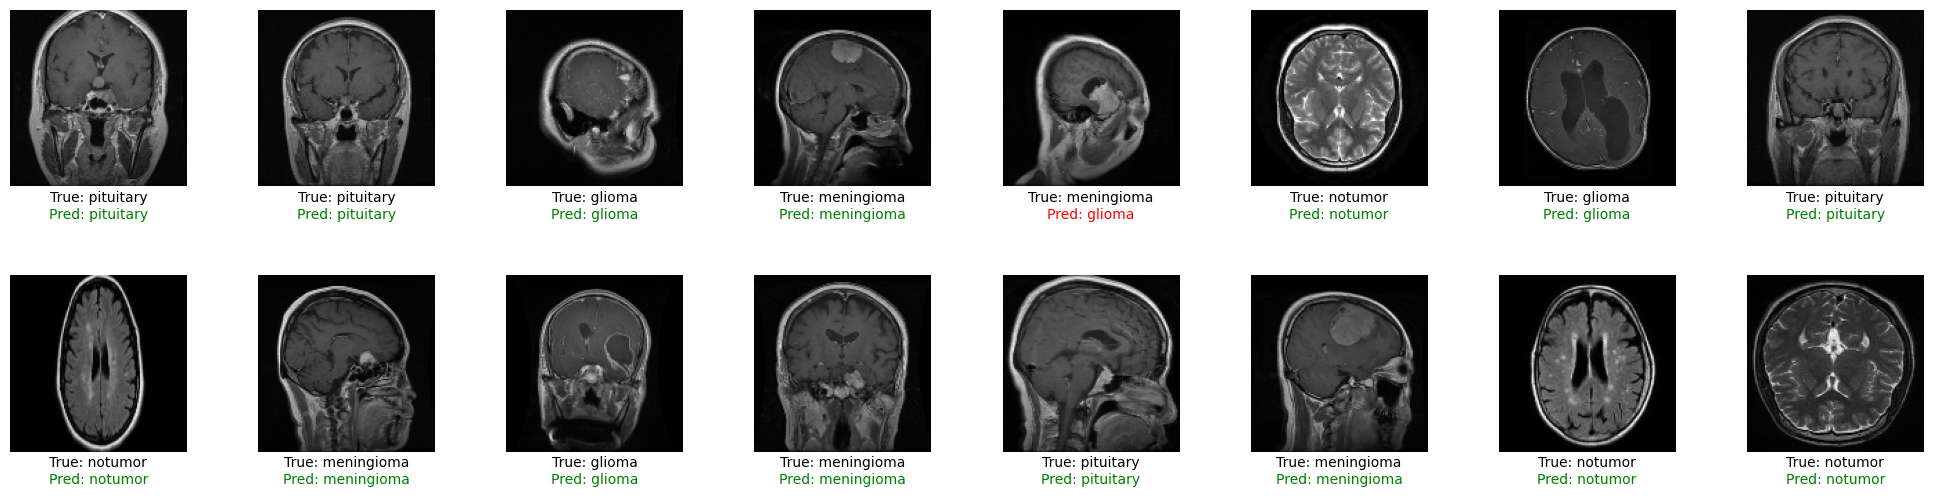

In [35]:
tumor_classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

fig, axes = plt.subplots(2, 8, figsize=(20, 5))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i])
    true_label = tumor_classes[y_test[i]]
    pred_label = tumor_classes[test_predictions[i]]
    
    if true_label == pred_label:
        color = 'green'
    else:
        color = 'red'
    
    ax.text(0.5, -0.1, f"True: {true_label}", color='black', transform=ax.transAxes, ha="center", va="bottom")
    ax.text(0.5, -0.2, f"Pred: {pred_label}", color=color, transform=ax.transAxes, ha="center", va="bottom")
    
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(hspace=0.5) 
plt.show()
